#   Hipótese 4

#   Bibliotecas

In [1]:
import pandas as pd
import random 
import numpy as np
import re
from scipy.sparse import hstack #utilizada para a junção de matrizes

In [2]:
#Pré processamento de colunas

from sklearn.model_selection import train_test_split #Divisão do dataset entre treino e teste
from sklearn.feature_extraction.text import TfidfVectorizer #vetorização do dataset
from sklearn.preprocessing import OneHotEncoder #aplicação de dummy

In [3]:
#Pré processamento de texto


import nltk
from nltk import word_tokenize #tokenizador
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords   #stopword

stop_words = stopwords.words('english')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
#import de funções do arquivo pre_processamento

from pre_processamento import pre_processamento, text_preprocess, textcolumns_junct,stemming

In [5]:
# Modelo a ser testado

from lightgbm import LGBMRegressor

In [6]:
#metricas

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

In [7]:
train = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\train.tsv", sep='\t')
test = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\test.tsv", sep='\t')

In [8]:
train,test = pre_processamento(train,test)

In [9]:
train = train.drop(train[~((train['price'] > 0) & (train['price'] < 250))].index)

In [10]:
X = train.drop("price", axis = 1)
y = train["price"]

In [11]:
X.shape

(1475215, 12)

#   Pré-processamento 

In [12]:
X = textcolumns_junct(X) #Função pra juntar as colunas de texto em uma só coluna

In [13]:
#Convertendo tudo para string

X["item_description"] = X["item_description"].astype(str)

In [14]:
X["item_description"] = X["item_description"].apply(lambda x: text_preprocess(x)) #Limpando texto com regex.


In [15]:
X["item_description"] = X["item_description"].apply(lambda x: word_tokenize(x)) #tokenizando

In [16]:
X["item_description"] = X["item_description"].apply(lambda x: stemming(x))

In [17]:
X["item_description"]=[" ".join(review) for review in X["item_description"].values]

In [18]:
X.head()

,item_condition_id,category_name,shipping,item_description,stock,gen_cat,sub1_cat,sub2_cat,datetime_month,datetime_year
0,3,Men/Tops/T-shirts,1,mlb cincinnati red shirt size xl descript yet,27,Men,Tops,T-shirts,6.0,2018.0
1,3,Electronics/Computers & Tablets/Components & P...,0,razer blackwidow chroma keyboard razer keyboar...,15,Electronics,Computers & Tablets,Components & Parts,3.0,2018.0
2,1,Women/Tops & Blouses/Blouse,1,ava viv blous target ador top hint lace key ho...,14,Women,Tops & Blouses,Blouse,10.0,2018.0
3,1,Home/Home Décor/Home Décor Accents,1,leather hors statu new tag . leather hors . re...,1,Home,Home Décor,Home Décor Accents,3.0,2018.0
4,1,Women/Jewelry/Necklaces,0,24k gold plate rose complet certif authent,13,Women,Jewelry,Necklaces,5.0,2018.0


In [19]:
X["item_description"]

0              mlb cincinnati red shirt size xl descript yet
1          razer blackwidow chroma keyboard razer keyboar...
2          ava viv blous target ador top hint lace key ho...
3          leather hors statu new tag . leather hors . re...
4                 24k gold plate rose complet certif authent
                                 ...                        
1482530    free peopl inspir dress free peopl lace say si...
1482531    littl mermaid handmad dress disney littl merma...
1482532    21 day fix contain eat plan use twice still gr...
1482533    world market lantern 2 one see 2 red 2 orang 2...
1482534    brand new lux de vill wallet new tag red spark...
Name: item_description, Length: 1475215, dtype: object

#   Split

In [20]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de validação de possíveis vazamentos. 

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.2, random_state=10) #Divisão em 80/20

<AxesSubplot:>

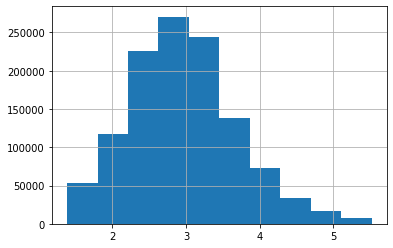

In [21]:
#Normalizando, com log, o target (price), foi realizado de forma separada para nao terem dados vazados.

ytrain =  np.log1p(ytrain)
ytrain.hist()

# Transformadores

In [22]:
vec = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), max_features=100000) #vetorização, com stop word. 

In [23]:
vec_train = vec.fit_transform(Xtrain["item_description"])

vec_train

<1180172x100000 sparse matrix of type '<class 'numpy.float64'>'
	with 33983033 stored elements in Compressed Sparse Row format>

In [24]:
vec_val = vec.transform(Xval["item_description"])

vec_val

<295043x100000 sparse matrix of type '<class 'numpy.float64'>'
	with 8485043 stored elements in Compressed Sparse Row format>

In [25]:
ohe = OneHotEncoder(handle_unknown="ignore")

#aplicação dummy nas colunas categóricas.

ohe_train = ohe.fit_transform(Xtrain[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])
                            
ohe_train

<1180172x997 sparse matrix of type '<class 'numpy.float64'>'
	with 5900860 stored elements in Compressed Sparse Row format>

In [26]:
ohe_val = ohe.transform(Xval[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])

ohe_val

<295043x997 sparse matrix of type '<class 'numpy.float64'>'
	with 1475208 stored elements in Compressed Sparse Row format>

In [27]:
#juntando cada matrix gerada por cada pré-processamento

x_train = hstack([
                 (vec_train),
                 (ohe_train)
                            ]) 
x_train

<1180172x100997 sparse matrix of type '<class 'numpy.float64'>'
	with 39883893 stored elements in Compressed Sparse Row format>

In [28]:
x_val = hstack([
                 (vec_val),
                 (ohe_val),
                             ]) 
x_val

<295043x100997 sparse matrix of type '<class 'numpy.float64'>'
	with 9960251 stored elements in Compressed Sparse Row format>

# Modelo baseline

In [29]:
lgb = LGBMRegressor(device = "gpu", random_state=10)

In [30]:
model = lgb.fit(x_train, ytrain)

In [32]:
ypredict = model.predict(x_val)

In [33]:
ypredict = np.expm1(ypredict)

# Modelo sem coluna de texto

In [34]:
lgb2 = LGBMRegressor(device = "gpu", random_state=10)

In [39]:
model_no_text = lgb2.fit(ohe_train, ytrain)

In [40]:
ypredict_no_text = model_no_text.predict(ohe_val)

#   Modelo com coluna de texto apenas

In [41]:
lgb3 = LGBMRegressor(device = "gpu", random_state=10)

In [42]:
model_text = lgb3.fit(vec_train, ytrain)

In [43]:
ypredict_text = model_text.predict(vec_val)

#   Resultados

- predict baseline

In [44]:
print('MAE: %2f' % mean_absolute_error(yval,ypredict))
print('RMSE: %2f' % (mean_squared_error(yval,ypredict)))
print('RMSLE: %2f' % mean_squared_log_error(yval,ypredict))
print('r2: %2f' % r2_score(yval,ypredict))


MAE: 10.848795
RMSE: 445.190671
RMSLE: 0.275238
r2: 0.345649


- predict com texto apenas

In [49]:
print('MAE: %2f' % mean_absolute_error(yval,ypredict_text))
print('RMSE: %2f' % (mean_squared_error(yval,ypredict_text)))
print('RMSLE: %2f' % mean_squared_log_error(yval,ypredict_text))


MAE: 22.161657
RMSE: 1160.192886
RMSLE: 2.984004


- predict sem texto

In [48]:
print('MAE: %2f' % mean_absolute_error(yval,ypredict_no_text))
print('RMSE: %2f' % (mean_squared_error(yval,ypredict_no_text)))
print('RMSLE: %2f' % mean_squared_log_error(yval,ypredict_no_text))


MAE: 22.161916
RMSE: 1162.845396
RMSLE: 2.997314


#   Conclusão

Observada queda acentuda de performace utilizando apenas features de texto ou apenas features categóricas.